In [21]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sktime.transformations.series.outlier_detection import HampelFilter
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm 
from scipy import stats
from sklearn.decomposition import PCA
from statsmodels.compat import lzip
import warnings
warnings.filterwarnings('ignore')

### 1.  Download Closing Prices fors: Merck & Co Inc (MRK) [Pharmaceutical] and Morgan Stanley (MS) [Financial]

In [23]:
stocks = ['MRK', 'MS']
stock_data = yf.download(stocks, start='2019-1-1', end='2024-12-31')['Close']

[*********************100%***********************]  2 of 2 completed


### 2. Create DataFrame

In [5]:
df_close = pd.DataFrame(stock_data)
df_close

Ticker            MRK          MS
Date                             
2019-01-02  59.139881   32.689911
2019-01-03  57.927212   32.107319
2019-01-04  59.671917   33.418148
2019-01-07  59.014713   33.749897
2019-01-08  59.452839   33.539520
...               ...         ...
2024-12-23  97.542267  121.797180
2024-12-24  97.620789  124.351540
2024-12-26  98.033073  125.300865
2024-12-27  97.866196  124.057938
2024-12-30  96.560661  123.069473

[1509 rows x 2 columns]

### 3. Plotting a Timeline for Closing Stock Prices

<Figure size 640x480 with 0 Axes>

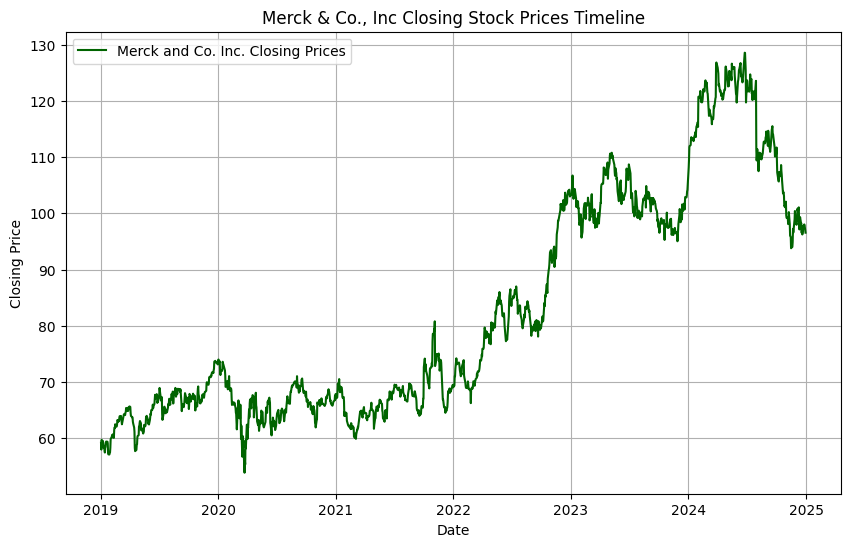

In [7]:
plt.figure(dpi=100)

plt.figure(figsize=(10, 6))
plt.plot(df_close['MRK'], label = 'Merck and Co. Inc. Closing Prices', color='darkgreen')
plt.title("Merck & Co., Inc Closing Stock Prices Timeline")
plt.ylabel("Closing Price")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df_close['MS'], label="Morgan Stanley Closing Stock Prices", color='royalblue')
plt.title("Morgan Stanley Closing Stock Prices Timeline")
plt.ylabel("Closing Price")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

This figure shows MRK and MS closing prices from 2019-2025, emphasising volatility and stability. The stock prices vary in magnitude thus they were plotted separately.

MS fluctuates sharply, especially during the COVID-19 crash, indicative of financial sector instability. MS shows an upward trend thereafter but remains volatile due to inflation and interest rate increases from 2022 - late 2023.

MRK’s steady growth is fuelled by strong drug sales and COVID-19-related products but declines in late 2024 due to falling sales and a lowered sales forecast. 

Both stocks see volatility in late 2024, likely from political tensions. MS’s variability reflects market sensitivity, while MRK’s stability underscores its defensive healthcare nature.

### 4. Daily Differenced Log Returns

In [10]:
df_close['MRK_Returns'] = np.log(df_close['MRK'] / df_close['MRK'].shift(1))
df_close['MS_Returns'] = np.log(df_close['MS'] / df_close['MS'].shift(1))

### 5. Checking for Missing Values / Head / Tail

In [16]:
df_close.info()
df_close = df_close.dropna()
df_close.head()
df_close.tail(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1509 entries, 2019-01-02 to 2024-12-30
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MRK          1509 non-null   float64
 1   MS           1509 non-null   float64
 2   MRK_Returns  1508 non-null   float64
 3   MS_Returns   1508 non-null   float64
dtypes: float64(4)
memory usage: 58.9 KB


Ticker             MRK          MS  MRK_Returns  MS_Returns
Date                                                       
2024-12-16  100.059998  128.177109    -0.011230    0.012713
2024-12-17  100.059998  126.895638     0.000000   -0.010048
2024-12-18   98.339996  120.239929    -0.017339   -0.053876
2024-12-19   99.519997  119.703499     0.011928   -0.004471
2024-12-20   98.050003  122.624069    -0.014881    0.024105
2024-12-23   99.370003  123.627388     0.013373    0.008149
2024-12-24   99.449997  126.220131     0.000805    0.020755
2024-12-26   99.870003  127.183723     0.004214    0.007605
2024-12-27   99.699997  125.922119    -0.001704   -0.009969
2024-12-30   98.370003  124.918793    -0.013430   -0.008000

### 6. Save DataFrame as CSV

In [18]:
df_close.to_csv('df_close.csv')

### 7. Summary Statistics of Stock Returns

In [22]:
df_close[['MRK_Returns', 'MS_Returns']].describe()

Ticker  MRK_Returns   MS_Returns
count   1508.000000  1508.000000
mean       0.000325     0.000879
std        0.014370     0.021306
min       -0.103840    -0.169603
25%       -0.006605    -0.009043
50%        0.000450     0.000958
75%        0.007782     0.011519
max        0.080421     0.180404

The average daily return, as indicated by the mean of the returns, is larger for MS (0.000879) than for MRK (0.000325). In comparison to MRK (0.014370), MS has a higher standard deviation (0.021306), indicating a more variable distribution around the mean and, thus, greater volatility for MS's stock.

The range of daily returns is demonstrated by the minimum and maximum returns, where MS has a larger range (-0.1696 to 0.1804) than MRK (-0.1038 to 0.0804). This further suggests that MS offers more potential gains and losses on any one day, along with greater volatility in returns.

The distribution of returns if further illustrated through the percentiles, with MS's 75th percentile (0.0115) being higher than MRK's (0.0078), and its 25th percentile also showing larger negative returns. This suggests that while MS offers higher upside potential, it also comes with a greater downside risk measure of how spread out the returns are around the mean, which is also higher for MS (0.021306) than MRK (0.014370), suggesting that MS's returns are more variable and thus riskier.

Overall, MRK offers steady but lower returns, while MS offers greater average returns with more volatility. Both substantial loses and bigger gains could result from MS's volatility.

### 8. Correlation of MRK and MS Returns

In [28]:
df_close[['MRK_Returns', 'MS_Returns']].corr()

Ticker       MRK_Returns  MS_Returns
Ticker                              
MRK_Returns     1.000000    0.305472
MS_Returns      0.305472    1.000000

The correlation between returns is shows as a positive correlation of 0.305 between Merck & Co.’s and Morgan Stanley’s. Given this the stocks returns have a weak positive correlation, suggesting they move in the same direction. Even though MRK and MS in separate industries, both stocks will experience market-wide risks like interest rates and varying economic conditions. 


### 9. Plotting a Histogram for Stock Returns

In [32]:
fig1 = plt.figure(figsize=(10, 6), dpi=100)
plt.hist(df_close['MRK_Returns'], bins = 70, edgecolor = 'black', linewidth = 1, color = 'darkgreen')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.title('Distribution of  Merck & Co., Inc. Daily Stock Returns')
plt.savefig('MRK_hist_returns.png')
plt.grid(True)
plt.show()

fig2 = plt.figure(figsize=(10, 6), dpi=100)
plt.hist(df_close['MS_Returns'], bins = 70, edgecolor = 'black', linewidth = 1,color = 'royalblue')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.title('Distribution of Morgan Stanley Daily Stock Returns')
plt.grid(True)
plt.savefig('MS_hist_returns.png')
plt.show()


The histograms of MRK and MS's daily returns indicate a normal distribution as returns both resemble a bell-shaped curve that is almost symmetrical with minor deviations. Majority of returns are clustered around 0% returns showing stocks only experience small daily changes. The distribution of thin frequent tails indicates that MRK's returns have fewer frequent extreme positive and negative returns. The narrow value spread indicates less volatility. MS’s returns have a larger spread of values with outliers shown by gaps in the histogram indicating higher volatility. Additionally, MS’s returns have thicker tails further indicating a higher probability of extreme returns.

### 10. Timeline of Merck & Co. Inc. and Morgan Stanley's Returns

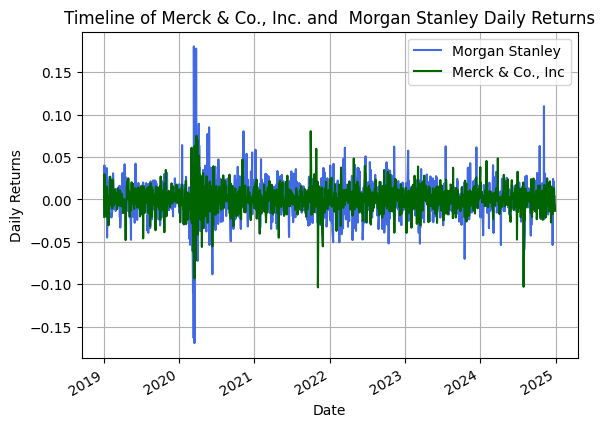

In [35]:
df_close['MS_Returns'].plot(label= 'Morgan Stanley', color = 'royalblue')
df_close['MRK_Returns'].plot(label= 'Merck & Co., Inc', color = 'darkgreen')
plt.title('Timeline of Merck & Co., Inc. and  Morgan Stanley Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid(True)
plt.show()

On the timeline, both stocks fluctuate around the mean of zero.  MS exhibits higher volatility clustering, with sharp pronounced spikes and dips in returns, around early 2020 reflecting the market turmoil during the COVID-19 pandemic.  MS’s exposure to the financial sector results in more return fluctuations. MRK appears to be less volatile as it experiences relatively stable returns, with fewer extreme variabilities, suggesting that the stock is less volatile. However, disruptions occur in late 2021 and 2024, driven by earnings disappointments, and shifting investor sentiment.  Neither stock follows a clear long-term trend, instead reacting to market specific challenges and broader macroeconomic conditions.

### 11. Checking Returns Series for Stationarity

In [38]:
# MRK Stationarity
# H0: Merck & Co. Inc. Daily Returns time series has a unit root [series is non-stationary]
# H1: Merck & Co. Inc. Daily Returns time series does not have a unit root [series is stationary]

print('Merck & Co. Inc. Augmented Dickey-Fuller Test:')
mrk_result = adfuller(df_close['MRK_Returns'])
print('ADF Statistic: %f' % mrk_result[0])
print('p-value: %f' % mrk_result[1])
print('Critical Values:')
for key, value in mrk_result[4].items():  
    print('\t%s: %.3f' % (key, value))            

Merck & Co. Inc. Augmented Dickey-Fuller Test:
ADF Statistic: -12.706721
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


In [39]:
# MS Stationarity
# H0: Morgan Stanley's time series has as unit root [series is non-stationary] 
# H1: Morgan Stanley's Daily Returns time series does not have a unit root [series is stationary]

print('Morgan Stanley Augmented Dickey-Fuller Test:')
ms_result = adfuller(df_close['MS_Returns'])
print('ADF Statistic: %f' % ms_result[0])
print('p-value: %f' % ms_result[1])
print('Critical Values:')
for key, value in ms_result[4].items():  
    print('\t%s: %.3f' % (key, value))

Morgan Stanley Augmented Dickey-Fuller Test:
ADF Statistic: -11.851906
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


The null hypothesis is rejected since Morgan Stanley's and Merck & Co., Inc.'s ADF test results are much below the crucial values. This demonstrates that the mean, variance, and autocorrelation of the daily returns of both stocks are stationary over time. These returns cause oscillations around a constant average. Even though short-term volatility fluctuations occur they do not persist and do not affect long-term trends ensuring a stable autocorrelation pattern. In contrast to stock prices, which typically follow a random walk, daily returns do not have a unit root and lack seasonality or cyclical patterns, thus showing that outliers or anomalies do not alter the return distribution over time. 

Furthermore, the ADF test p-values are essentially zero, enforcing statistical evidence to reject the null hypothesis. This stationarity suggests past returns do not provide suitable predictive power proving daily returns are unpredictable in the long term.

### 12. Checking Series for Outliers

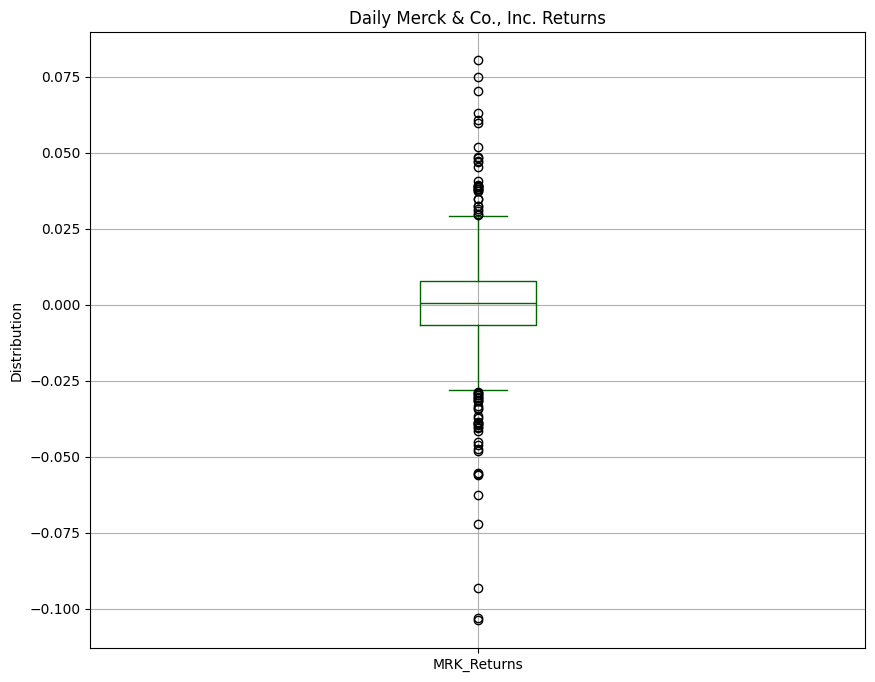

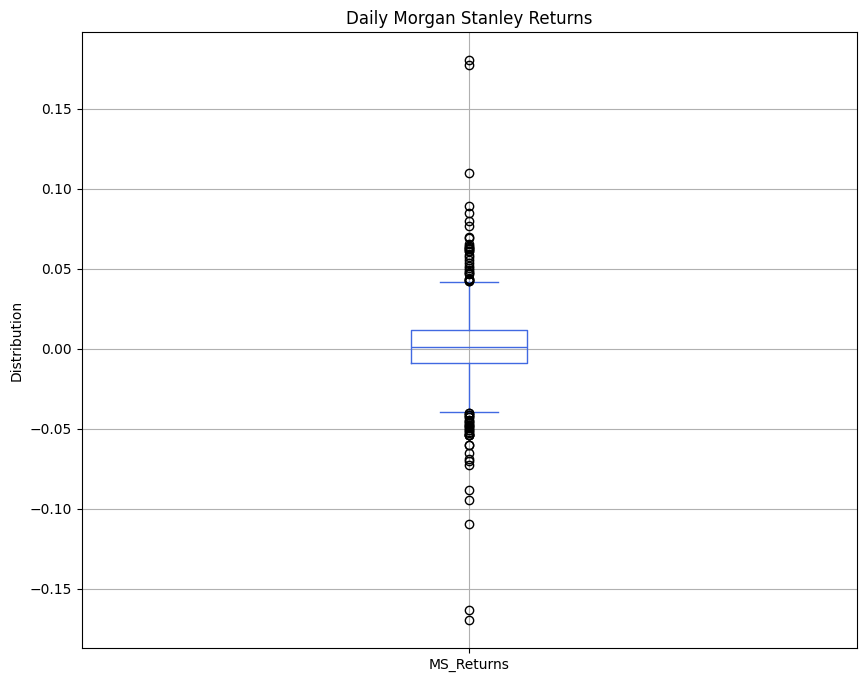

In [46]:
df_mrk_returns = pd.DataFrame(df_close['MRK_Returns'])
df_ms_returns = pd.DataFrame(df_close['MS_Returns'])


df_mrk_returns.plot.box(title='Daily Merck & Co., Inc. Returns', ylabel = 'Distribution', figsize = (10,8), grid = True, color = 'darkgreen')
plt.show()

df_ms_returns.plot.box(title= 'Daily Morgan Stanley Returns', ylabel = 'Distribution', figsize = (10,8), grid = True, color = 'royalblue')
plt.show()

Both the MRK and MS daily returns have medians near zero, indicating that 50% of daily returns are similarly distributed, and their interquartile ranges are alike indicating that their levels of dispersion are comparable. With fewer outliers and shorter whiskers, MRK shows an even return distribution with infrequently return movements.

Contrasting this MS’s returns have longer whiskers and more frequent extreme values indicating greater deviations from the mean and thus higher overall volatility. MS shows a higher percentage of returns outside the caps indicating higher unpredictable returns, unlike MRK where majority of the data is contained within the boxplot. 


### 13. Removing Outliers and Replotting

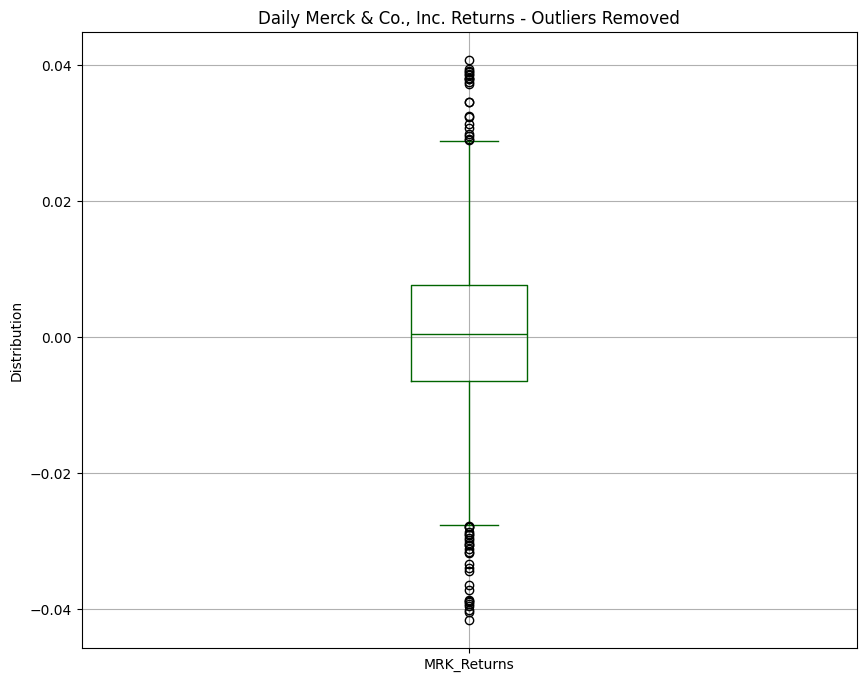

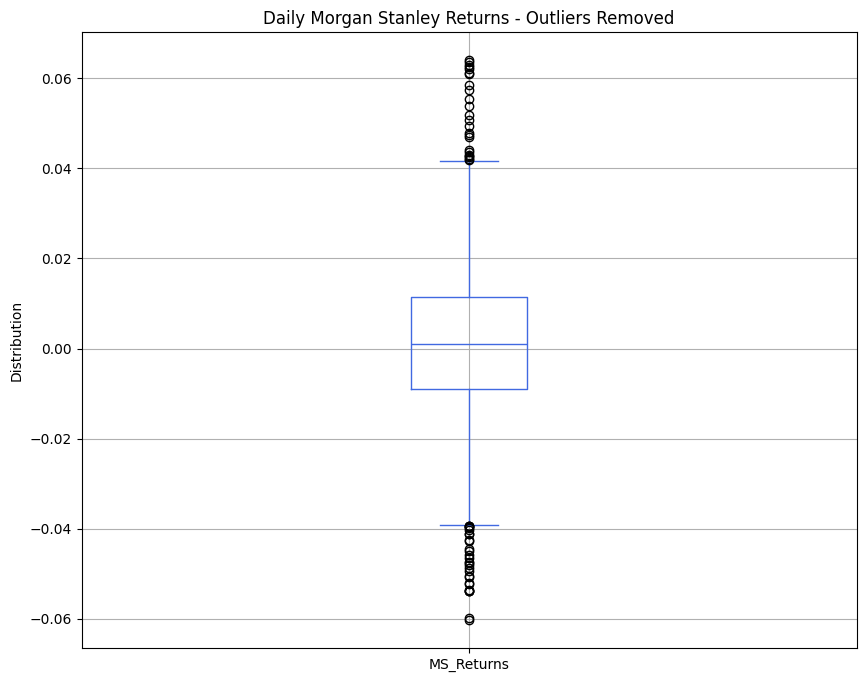

In [49]:
mrk_z_score= np.abs(stats.zscore(df_mrk_returns))
mrk_df = df_mrk_returns[(mrk_z_score< 3).all(axis=1)]

ms_z_score = np.abs(stats.zscore(df_ms_returns))
ms_df = df_ms_returns[(ms_z_score < 3).all(axis=1)]


mrk_df.plot.box(title='Daily Merck & Co., Inc. Returns - Outliers Removed', ylabel = 'Distribution', figsize = (10,8), grid = True, color = 'darkgreen')
plt.show()

ms_df.plot.box(title= 'Daily Morgan Stanley Returns - Outliers Removed', ylabel = 'Distribution', figsize = (10,8), grid = True, color = 'royalblue')
plt.show()



After removing the outliers, MRK maintains a median slightly above zero, confirming its consistent returns.  The narrower IQR indicates indicating infrequent volatility has been removed.  The whiskers removed the noise from extreme market movements. With the caps clearly outlining return limits fewer outliers outlining a more accurate view of its variations.

For MS the median remains near zero while the IQR is now narrower. This shows that MS had frequent daily return deviating from the mean. The whiskers suggest more controlled volatility. The reduction in outliers helps to gauge more typical returns, with this adjustment still presents MS as a still volatile stock.

### 14. Stocks on the Nikkei 225

In [54]:
tickers = ['7203.T' , '4578.T', '9984.T', '6952.T', '6861.T',
           '9432.T', '8035.T', '9983.T', '4063.T', '6501.T',
           '8058.T', '9433.T', '6902.T', '7974.T', '8001.T',
           '9022.T', '6098.T', '4661.T', '8031.T', '4568.T', 
           '4519.T', '7267.T', '8766.T', '6367.T', '2914.T',
           '2587.T', '7751.T', '5108.T', '6503.T', '5802.T']
           
close_prices= yf.download(tickers, start='2019-01-01', end= '2024-12-31')['Close']

[*********************100%***********************]  30 of 30 completed


The Nikkei 225 is the primary stock market index for the Tokyo Stock Exchange Prime Market. It is composed of the 225 most valuable publicly traded companies in Japan. 
Japanese yen is used to value the index. During trading hours, the index is computed every five seconds and revised twice a year. 

The Nikkei 225 is calculated utilising a weighted price methodology where higher-priced stocks have a greater impact.
The index is calculated where the adjusted price equals the summation of adjusted prices of constituents divided by the divisor (the scaling factor). Fast Retailing has the has the most impact on the index, making up 10% of its weight.


### 15. Cumulative Returns for Nikkei 225 Index Constituents

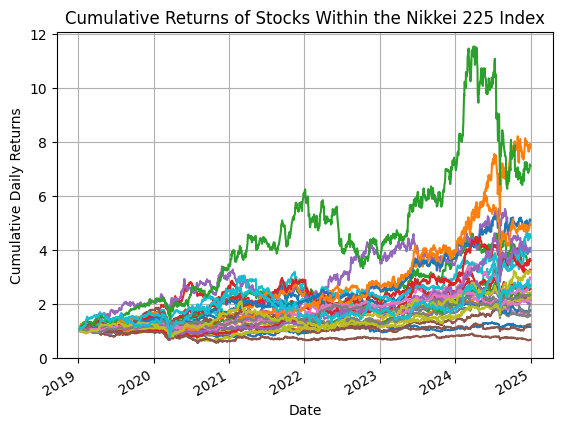

In [58]:
close_prices = pd.DataFrame(close_prices)
daily_returns = np.log(close_prices).diff(1)
cumulative_returns = daily_returns.cumsum().apply(np.exp)

cumulative_returns.plot(legend = False, grid=True, title='Cumulative Returns of Stocks Within the Nikkei 225 Index', ylabel = 'Cumulative Daily Returns')
plt.show()

The plot displays the cumulative returns of constituents within the Nikkei 225 index. The majority of stocks show positive cumulative returns over time as they gradually rise in value. After 2022, there is a clear rise in volatility and return dispersion among individual stocks.

The clustering of most stock cumulative returns indicates overall positive market performance, but with varying degrees of success. Some stocks show steady growth while others display greater volatility. The Nikkei 225 has the potential for notable outperformance, as evidenced by the difference between the top performer and the remainder of the index.


### 16. Saving Cumulative Returns

In [62]:
cumulative_returns.to_csv('cumulative_returns.csv')

### 17. Computing and Plotting First Principal Component

Ticker
2587.T    0.109162
2914.T    0.117020
4063.T    0.219583
4519.T    0.129396
4568.T    0.173182
4578.T    0.138574
4661.T    0.126151
5108.T    0.168054
5802.T    0.222380
6098.T    0.238446
6367.T    0.186357
6501.T    0.239316
6503.T    0.199637
6861.T    0.192829
6902.T    0.225093
6952.T    0.157044
7203.T    0.200519
7267.T    0.225801
7751.T    0.151406
7974.T    0.124613
8001.T    0.174649
8031.T    0.213929
8035.T    0.253564
8058.T    0.176415
8766.T    0.188059
9022.T    0.130701
9432.T    0.076693
9433.T    0.082696
9983.T    0.175903
9984.T    0.260690
dtype: float64

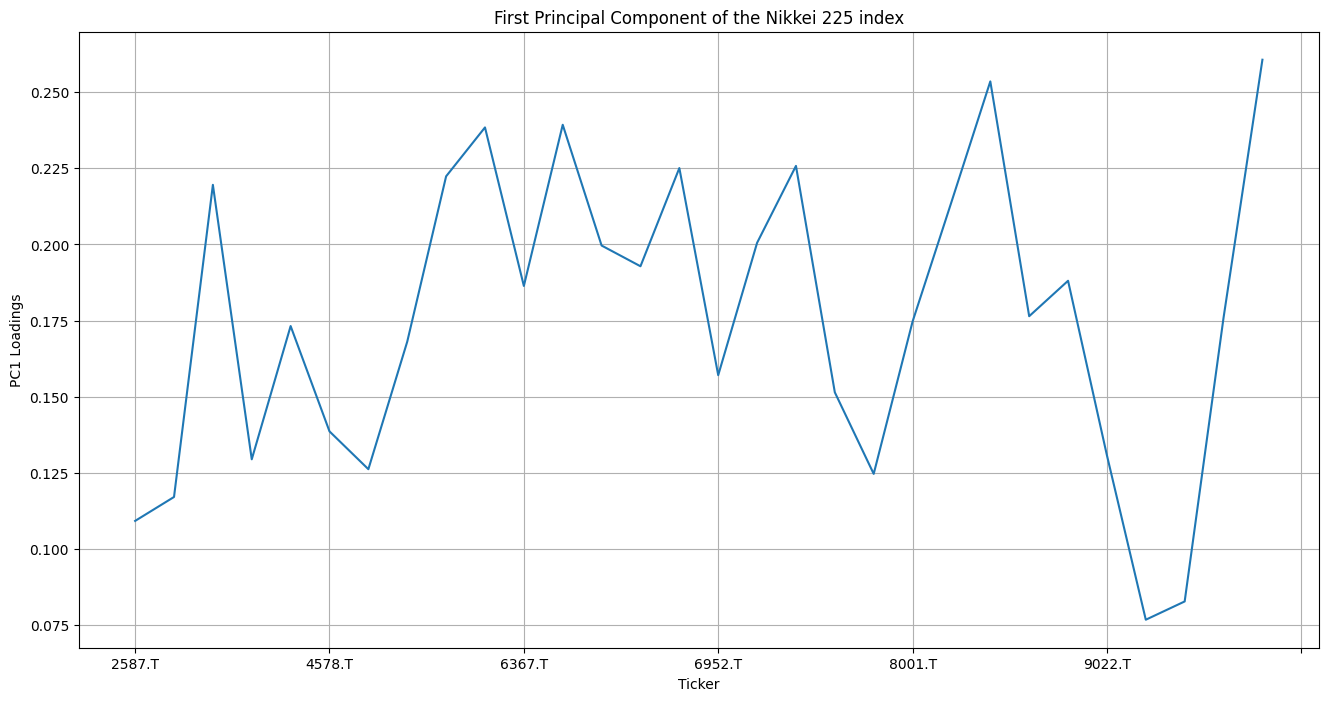

In [65]:
pca = PCA(1).fit(daily_returns.fillna(0))
pc1 = pd.Series(index=daily_returns.columns, data=pca.components_[0])
pc1.plot(figsize=(16, 8), grid = True, title='First Principal Component of the Nikkei 225 index', xlabel = 'Ticker', ylabel = 'PC1 Loadings')
pc1

The first principal component (PC1) of stocks within the Nikkei 225 captures the daily returns leadings to the greatest variability in the index. With loadings indicating the higher the variability of daily returns of a stock, monitoring high-loading stocks is essential for capturing market movements, while lower-loading stocks may provide diversification benefits, reducing overall portfolio volatility.

The stocks with the greatest influence are SoftBank Group Corp (9984.T) and Tokyo Electron Ltd. (8035.T). Both stocks are two of the largest companies by market cap in the index, with a higher weightage showing a stronger influence in the index. Thus, showing greater correlation between the stocks and the overall trend in the index.
SoftBank an investment holding company, exhibits the highest loading in the PC1. Their aggressive investment strategy in technology investments can lead to greater changes in daily returns causing the index returns to have high volatility. Tokyo Electron is a manufacturer of semiconductors. Their cyclical nature of the semiconductor industry and its sensitivity to global market trends, and with great market trends in AI the company is sensitive to investor sentiment. 

Nippon Telegraph and Telephone Corporation (9432.T) and KDDI Corporation (9433.T) have the lowest loadings, meaning their price movements are less correlated with the Nikkei 225. As telecommunications companies, their behaviour is more independent of the factors driving index movements. This sector is generally less sensitive to market fluctuations and economic trends due to its stable revenue streams. Telecommunication companies experience lower cyclicality and volatility, making them more resilient to economic shifts. Their financial stability and reduced correlation with broader market trends further insulate them from sensitivity to economic changes affecting the Nikkei 225.

### 18. Building a Portfolio with the 1st Principal Component

In [69]:
weights = abs(pc1)/sum(abs(pc1))
portfolio_returns = (weights*daily_returns).sum(1)
cumulative_portfolio = portfolio_returns.cumsum().apply(np.exp)

###  19. Plotting Cumulative Returns for the New Portfolio

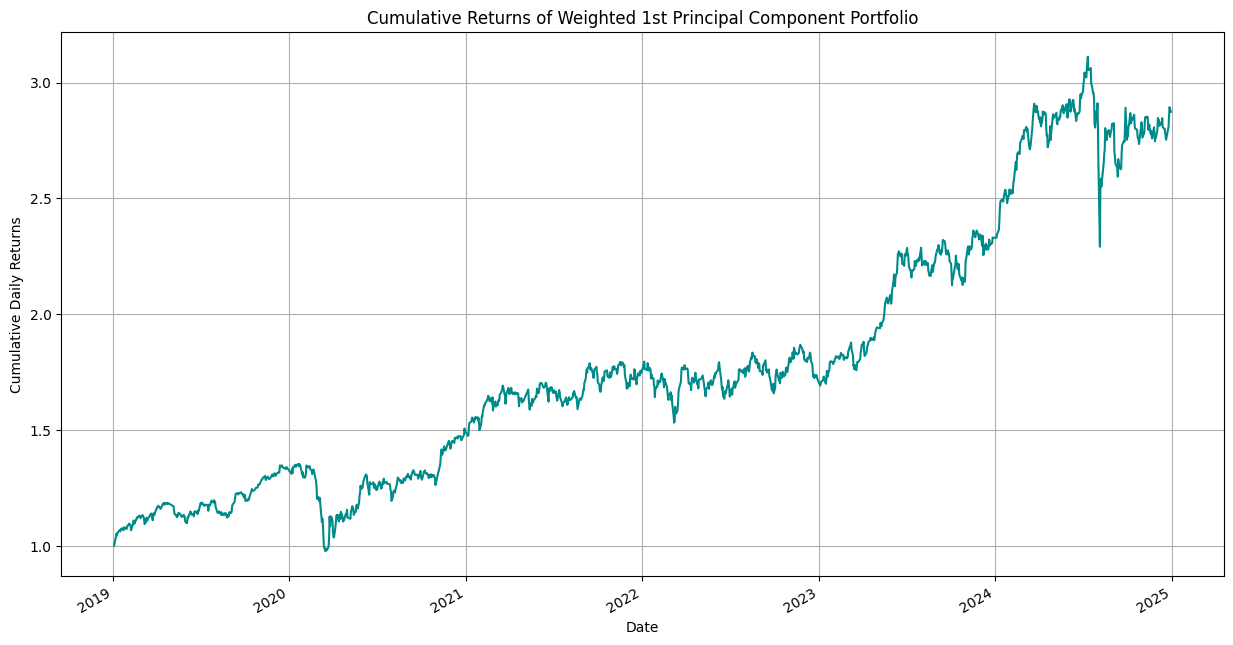

In [72]:
plt.figure(figsize=(15, 8))
cumulative_portfolio.plot(figsize = (15,8), grid = True, title = 'Cumulative Returns of Weighted 1st Principal Component Portfolio', xlabel = 'Date', ylabel = 'Cumulative Daily Returns', color = 'darkcyan')
plt.savefig('Cumulative_Portfolio_Returns.png')
plt.show()

The weighted portfolio performed well from 2019 to 2024 as seen by the cumulative returns plot. Between 2019 and 2020, there are phases of consolidation with small growth. Early in 2020, the COVID-19 shock caused a steep and quick decline in returns. After the shock there is quick return for growth as a result of the economic activity rebound brought on by stabilising markets. From 2021 until 2024, there is a slow upward during which time the growth of returns is more sluggish. Late in 2024, there is a lot of volatility, which could be caused by a market pullback or susceptibility to heavy loading stocks from the PC1.

###  20. Download Closing Prices for the Nikkei 225 Index

In [76]:
nikkei_225 = yf.download('^N225', start = '2019-01-01', end = '2024-12-31')['Close']

[*********************100%***********************]  1 of 1 completed


### 21. Differenced Log Returns for Nikkei 225 Index

In [79]:
nikkei225_returns= np.log(nikkei_225/ nikkei_225.shift(1))
nikkei225_returns.to_csv('nikkei225_returns.csv')

### 22. Portfolio vs. Nikkei 225 Returns

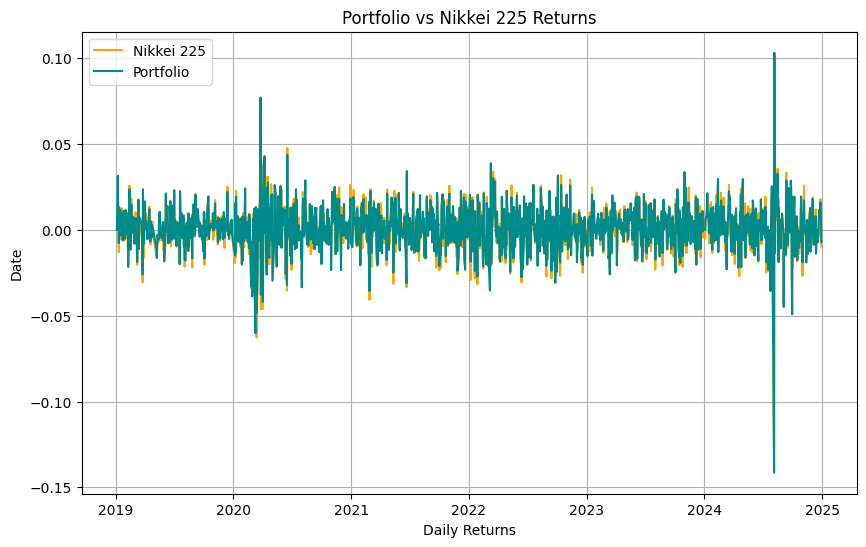

In [82]:
portfolio_returns = pd.DataFrame(portfolio_returns)
nikkei225_returns = pd.DataFrame(nikkei225_returns)

plt.figure(figsize=(10, 6))
plt.plot(nikkei225_returns, label="Nikkei 225", color='orange')
plt.plot(portfolio_returns, label = 'Portfolio', color='darkcyan')
plt.title("Portfolio vs Nikkei 225 Returns")
plt.ylabel('Date')
plt.xlabel('Daily Returns')
plt.legend()
plt.grid(True)
plt.show()

The weighted portfolio returns follows the returns of the Nikkei 225 index. This is likely because the stocks weighted in the portfolio are the ones that drive the index, which have the highest variance and volatility. Both the portfolio and Nikkei 225 exhibit fluctuating daily returns, with noticeable volatility, especially during market stress periods such as early 2020 and late 2024. The returns of the portfolio and Nikkei 225 move in a similar pattern, suggesting a positive correlation. However, the portfolio does not precisely mirror the daily returns, though, because it does not have the same weighting from market capitalisation as the index. This is one of the minor differences between the portfolio and the Nikkei 225. A reduced portfolio size compared to the index means will lead to less exposure to smaller market trends from lower-loading PC1 stocks, causing the portfolio to move differently. Lastly, short-term deviations from the index are triggered by idiosyncratic risks.

### 23. Effect of the Covid 19 Pandemic on Individual Stock Returns

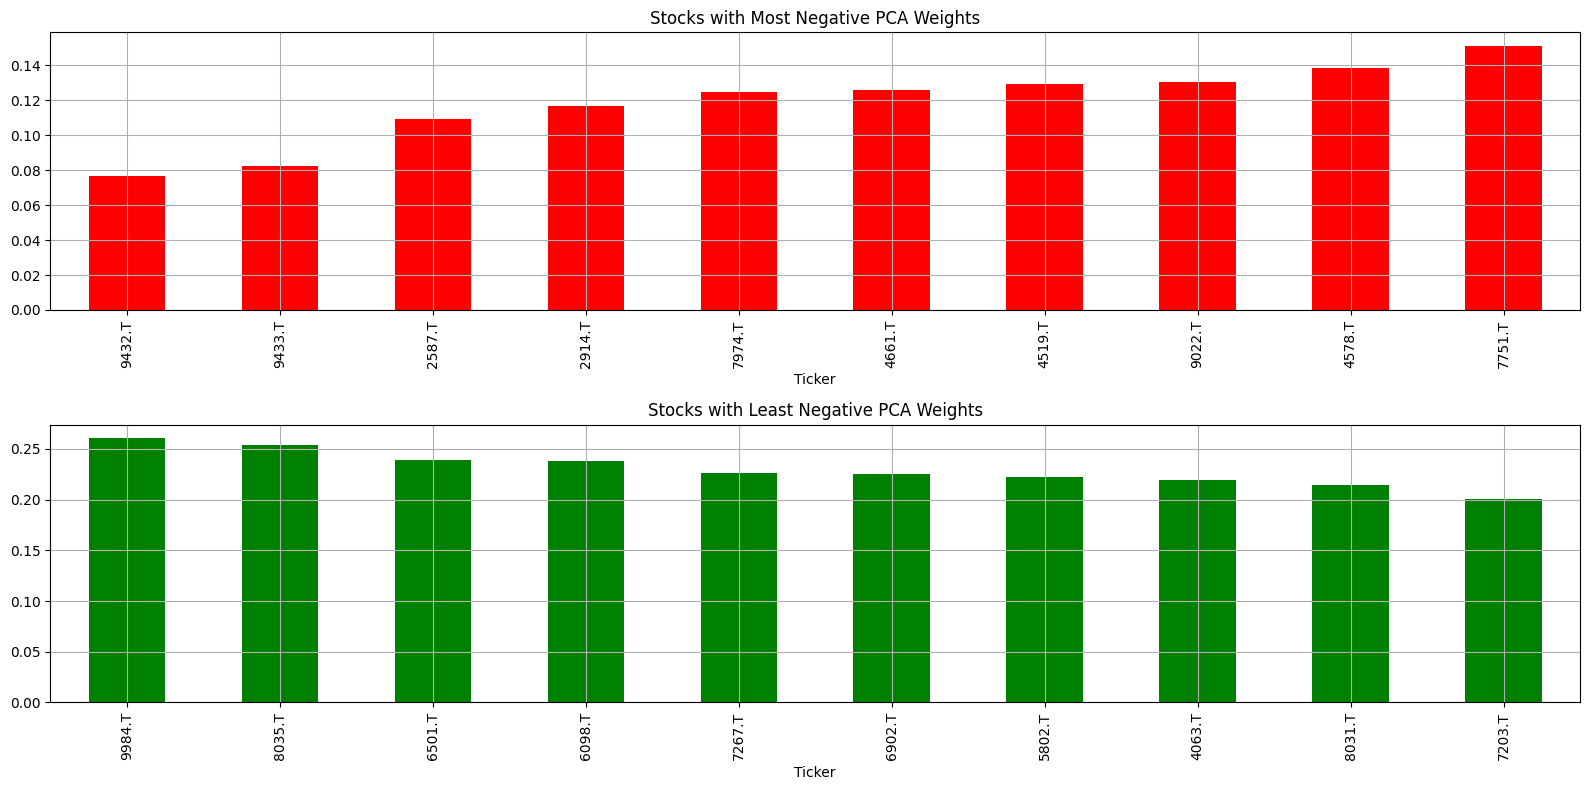

In [86]:
fig, ax = plt.subplots(2,1, figsize=(16,8))
pc1.nsmallest(10).plot.bar(ax=ax[0], color='red', grid=True, title='Stocks with Most Negative PCA Weights')
pc1.nlargest(10).plot.bar(ax=ax[1], color='green', grid=True, title='Stocks with Least Negative PCA Weights')
plt.tight_layout()

The bar charts provide important information on the market dynamics of different sectors. Stocks in the telecoms and consumer staples sectors, such as Nippon Telegraph and Telephone (9432.T), KDDI Corporation (9433), Suntory (2587.T), and Japan Tobacco International (2914.T), have shorter bars, indicating lower weightings and hence higher stability. Their important services and products, which were consistently in demand even during lockdowns, are the reason for this stability.

In contrast, financial services and technology firms like SoftBank Group (9984.T), Hitachi (6501.T), and Shinetsu (4063.T) have longer bars, reflecting higher weightings and more vulnerability to market movements due to their exposure to economic instability and supply chain disruptions. The longest bars indicate cyclical industries and trading companies, such as Tokyo Electron (8035.T), Denso Corporation (6902.T), Hino Motors Ltd (7203.T), and Mitsui & Co Ltd (8031.T), which are extremely sensitive to market conditions because of supply chain disruptions, a decline in consumer demand, and volatility in commodity prices. 

These insights provided by the calculation of the effect of the pandemic shows how understanding market dynamics of high PC1 weighted companies and industries can mitigate losses during future crises. The varying impacts of volatility highlight the ned for diversification in reducing exposure to companies and sectors with high sensitivity to market volatility and economic uncertainty.

### 24. Closing Prices for Telecom and Energy Company

In [90]:
tel_energy_tick = ['VOD.L', 'SSE.L']
vod_sse_data = yf.download(tel_energy_tick, start='2000-1-1', end='2024-12-31')['Close']
vod_sse_data

[*********************100%***********************]  2 of 2 completed


Ticker            SSE.L       VOD.L
Date                               
2000-01-03   487.714569  362.961914
2000-01-04   489.441376  348.765137
2000-01-05   495.362122  331.847412
2000-01-06   508.436920  321.791382
2000-01-07   514.111023  339.892120
...                 ...         ...
2024-12-20  1605.787720   66.500000
2024-12-23  1604.287964   66.480003
2024-12-24  1605.287842   67.760002
2024-12-27  1606.787598   67.339996
2024-12-30  1611.287109   67.220001

[6364 rows x 2 columns]

### 25. Differenced Log Returns and Dataframe Plotting

In [93]:
vod_sse_data['vod_ret'] = np.log(vod_sse_data['VOD.L'] / vod_sse_data['VOD.L'].shift(1))
vod_sse_data['sse_ret'] = np.log(vod_sse_data['SSE.L'] / vod_sse_data['SSE.L'].shift(1))
df_vod_sse = pd.DataFrame(vod_sse_data)

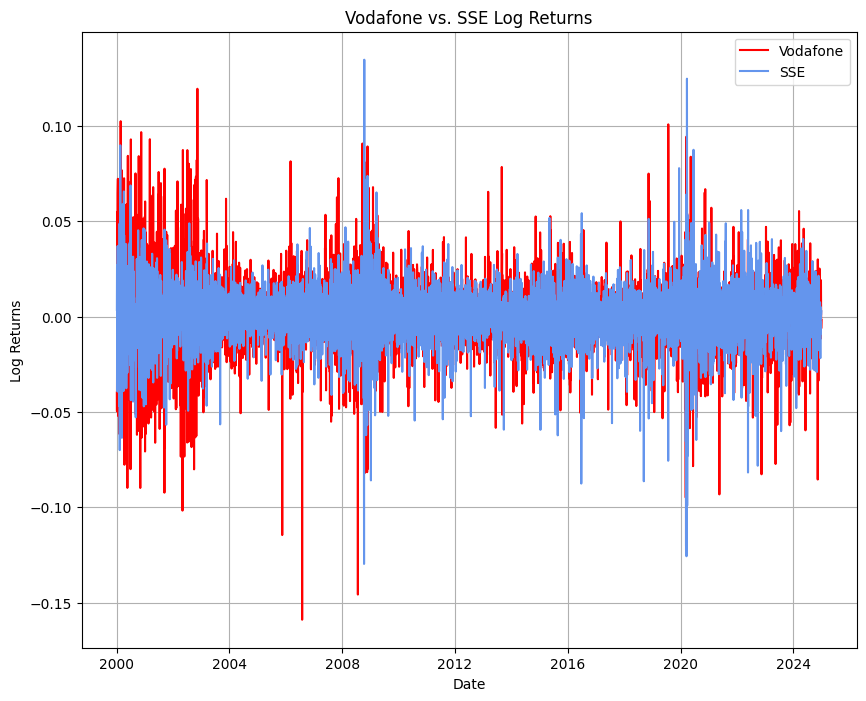

In [95]:
plt.figure(figsize=(10, 8))
plt.plot(vod_sse_data['vod_ret'], label = 'Vodafone', color='red')
plt.plot(vod_sse_data['sse_ret'], label= 'SSE', color='cornflowerblue')
plt.title("Vodafone vs. SSE Log Returns")
plt.ylabel("Log Returns")
plt.xlabel("Date")

plt.legend()
plt.grid(True)
plt.show()

The timeline shows the daily log returns of Vodafone and SSE illustrating the volatility of their stock values. Vodafone has more volatility with more noticeable spikes, indicating larger daily percentage changes, yet both stocks oscillate around a mean of zero signifying mean reversion. Although their movements seem to have some correlation, significant variations in peaks and troughs point to times when their performance deviates. The variance of daily returns is reflected from market and company events, with returns vary occasionally being greater 0.1 and less than -0.1.

### 26. Saving Returns as a CSV File

In [99]:
returns = vod_sse_data.iloc[:, 2:4]
returns.to_csv('vod_sse_returns.csv')

### 27. Plotting Histogram of Vodafone and SSE Returns

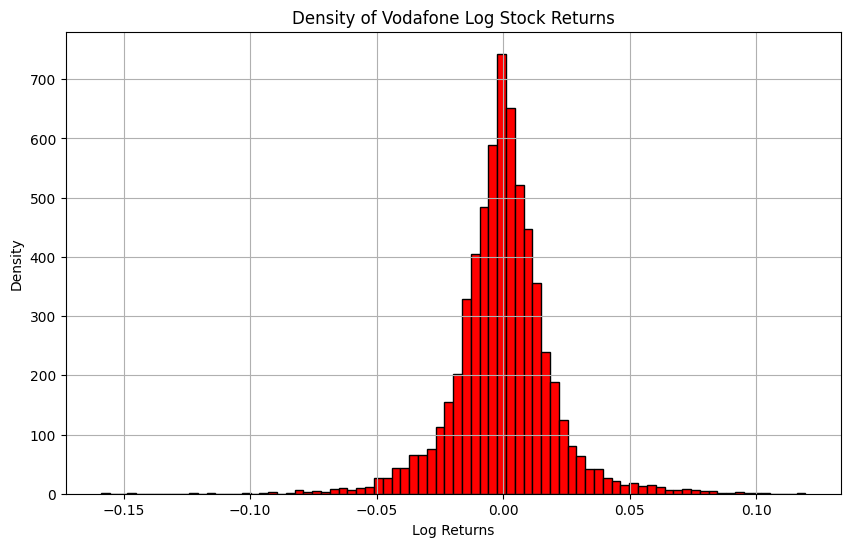

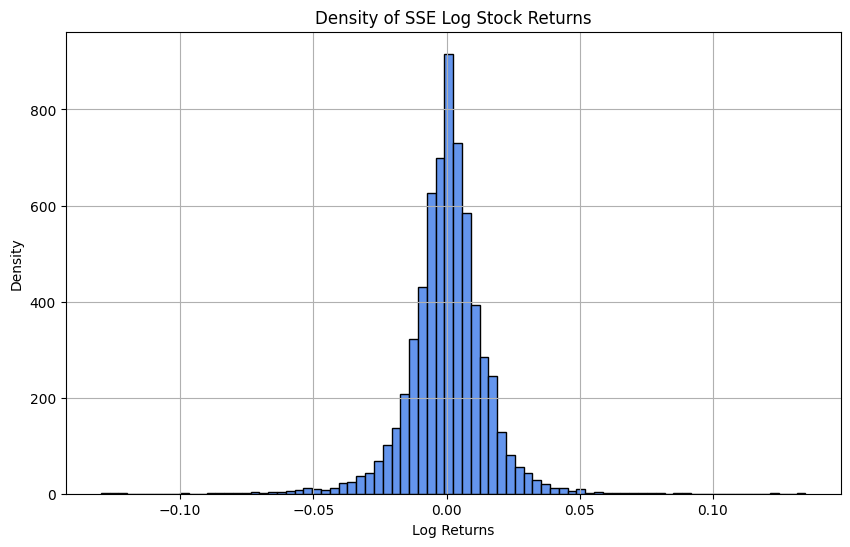

In [264]:
fig1 = plt.figure(figsize=(10, 6), dpi=100)
plt.hist(vod_sse_data['vod_ret'], bins = 80, edgecolor = 'black', linewidth = 1, color = 'red')
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.title('Density of Vodafone Log Stock Returns')
plt.grid(True)
plt.show()

fig2 = plt.figure(figsize=(10, 6), dpi=100)
plt.hist(vod_sse_data['sse_ret'], bins = 80, edgecolor = 'black', linewidth = 1, color = 'cornflowerblue')
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.title('Density of SSE Log Stock Returns')
plt.grid(True)
plt.show()

The density histograms of Vodafone and SSE's daily log returns, revealing the normality of the data visually through the histograms both being a symmetrical bell-shaped. Both distributions exhibit a pronounced peak around zero, where small daily returns are far more frequent, with slight deviations from zero. Both histograms are evenly spread with very few outliers or gaps.  than expected under a normal distribution. Vodafone seems to be slightly skewed towards negative daily returns, SSE looks to have a marginal skew towards positive daily returns.

### 28. Summary Statistics for Dataframe

In [279]:
returns.describe()

Ticker      vod_ret      sse_ret
count   6363.000000  6363.000000
mean      -0.000047     0.000396
std        0.019305     0.014366
min       -0.159010    -0.129754
25%       -0.009428    -0.006582
50%        0.000000     0.000000
75%        0.009251     0.007582
max        0.119474     0.134709

An overview of Vodafone and SSE's risk and return characteristics can be seen in the daily return summary statistics. SSE produced greater daily returns on average, as evidenced by the slightly positive mean daily return compared to Vodafone's slightly negative mean. 
Vodafone's higher standard deviation implies that there is more volatility and a wider range of possible daily price movements. The median return for both stocks is zero, meaning that half of the daily returns were negative, and the other half were positive. The amount of extreme price changes is shown by the minimum and maximum returns, with Vodafone seeing a bigger decline and a smaller gain in comparison to the SSE range. The distribution of returns is further demonstrated by the 25th and 75th percentiles, which show a broader distribution for Vodafone. 


### 29. Correlation, Skewness, and Kurtosis of Returns

In [68]:
returns.cov()

Ticker    vod_ret   sse_ret
Ticker                     
vod_ret  0.000378  0.000073
sse_ret  0.000073  0.000206

In [70]:
returns.kurtosis()

Ticker
vod_ret    5.055161
sse_ret    8.580626
dtype: float64

In [64]:
returns.skew()

Ticker
vod_ret   -0.073216
sse_ret   -0.268896
dtype: float64

The returns of Vodafone and SSE are moderately positively correlated. This suggests that although their association is weak, they do tend to move relatively in the same direction. 


Vodafone and SSE experience excessive kurtosis. Both stock daily returns have values above three, which indicates leptokurtosis with fatter tails and a steeper peak, whereas a normal distribution has a kurtosis of three. Leptokurtosis is indicated by values greater than 3. Given its higher kurtosis, SSE appears to have more extreme values than Vodafone and more extreme values than a normal distribution would predict. 

Both Vodafone and SSE exhibit negative skewness, indicating that the distributions are slightly skewed to the left, with more frequency for negative daily returns than positive daily returns. SSE's more negative skewness suggests a higher probability of large negative returns compared to Vodafone.


### 30. OLS Regression

In [17]:
#Telecom (dependent)
#Energy (independent)

reg = smf.ols(formula = 'vod_ret ~ sse_ret', data=returns)
reg_results = reg.fit()
print(reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:                vod_ret   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     441.7
Date:                Fri, 28 Feb 2025   Prob (F-statistic):           7.24e-95
Time:                        02:50:07   Log-Likelihood:                 16253.
No. Observations:                6363   AIC:                        -3.250e+04
Df Residuals:                    6361   BIC:                        -3.249e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0003      0.000     -1.392      0.1

The OLS regression examines the relationship between Vodafone’s daily returns and SSE’s daily returns over 6363 observations. The analysis indicates a statistically significant positive relationship (with high F-statistic:441.7, confirmed by p < 0.001). This suggests that SSE’s performance influences Vodafone’s returns. The SSE returns coefficient implies that a 1% increase in returns from SSE leads to a 0.337% increase in Vodafone’s returns. 

However, the regression’s explanatory lower is weak. With the R-squared affirming that SSE returns only account for 6.5% of Vodafone’s return variability. Suggesting factors such as Telecommunication market trends play a far greater role in explaining return variability. 

The diagnostic rests highlight that the residuals are non-normal, thus violating the regression assumptions.  This is supported by the Omnibus (p < 0.001) and Jarque-Bera (p < 0.001) tests, which show possible outliers with high kurtosis (8.489) and nearly zero skewness (-0.024). On the other hand, the condition number (68.0) suggests no significant multicollinearity, and the Durbin-Watson statistic (2.048) suggests no autocorrelation.

In conclusion, although if the association is statistically significant, the model's dependability is compromised by its low R-squared, non-normal residuals, and limited explanatory power, which calls for a more thorough analysis of Vodafone's stock performance.

###  31. Calculating Regression Residuals

In [19]:
# Calculate regression residuals
residuals = reg_results.resid

#### 1. Testing Residuals For Non-Normality

- Assumption 1 : Error Terms are normally distributed. If not normally distributed, randomness is lost. Therefore, the model is not able to explain the relation in the data
- Assumption 2: Zero mean assumption. Residuals have a mean of zero [error terms are normally distributed around zero].

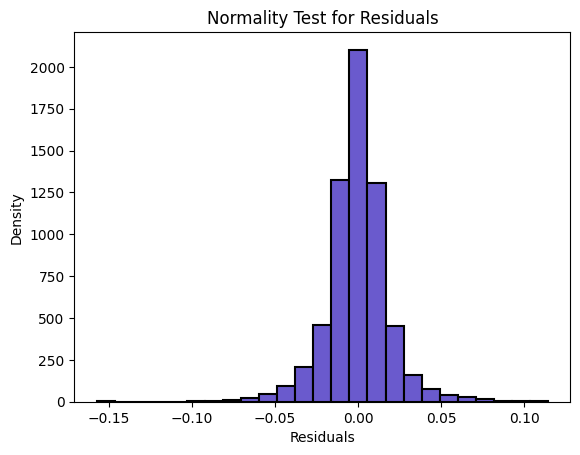

In [21]:
plt.figure(1)
plt.hist(residuals, 25, edgecolor = 'black', linewidth= 1.5, color = 'slateblue')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Normality Test for Residuals')
plt.show()

In [27]:
# Running a Test For Non-Normality:
    # H0: Residuals are normally distributed

name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test_ = sms.jarque_bera(residuals)
lzip(name, test_)

[('Jarque-Bera', 7988.115384520981),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', -0.02436844496253142),
 ('Kurtosis', 8.48882904366373)]

#### 2. Testing Residuals for Autocorrelation
- Assumption 3: Independent errors. Residual terms are independent of each other. There is no correlation between residuals and the predicted values or among the residuals themselves.

In [286]:
# No autocorrelation
#H0: Residuals of time series data are uncorrelated

name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test_1 = sms.acorr_breusch_godfrey(reg_results, 10)
lzip(name,test_1)

2.0479686646152833

#### 3. Testing Residuals For Heteroscedasticity
- Assumption 4: Constant variance. Residual terms have the same variance which is known

In [29]:
# Running the Test for Heteroskedacity [Breusch-Pagan]

name =  ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test_2 = sms.het_breuschpagan(reg_results.resid, reg_results.model.exog)
lzip(name, test_2)

[('Lagrange multiplier statistic', 3.519762966102194),
 ('p-value', 0.06064111956411837),
 ('f-value', 3.52060410487533),
 ('f p-value', 0.06065610109606871)]

#### 4. Linearity

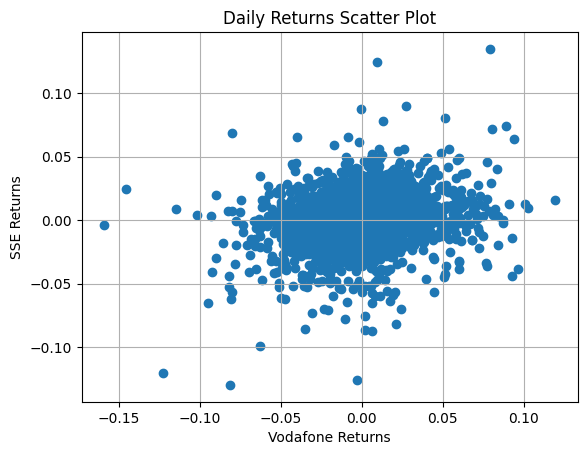

In [31]:
plt.scatter(vod_sse_data['vod_ret'], vod_sse_data['sse_ret'])
plt.xlabel('Vodafone Returns')
plt.ylabel('SSE Returns')
plt.title('Daily Returns Scatter Plot')
plt.grid(True)
plt.show()

Several insights are revealed by the residual analysis done for the assumptions of the Classical Linear Regression Model violation. First, the residuals are not normally distributed, according to the histogram and the Jarque-Bera test. With a p-value of zero and an exceptionally high Jarque-Bera test statistic (7988.11), the null hypothesis of normalcy is rejected. This raises the possibility of residual randomness problems, which could compromise the validity of statistical inference. Second, there is no apparent evidence of autocorrelation in the residuals when the Breusch-Godfrey test for autocorrelation produces a p-value larger than 0.05. This satisfies the assumption of independent errors, ensuring that residuals are not correlated over time.
Third, the null hypothesis of constant variance is rejected when the Breusch-Pagan test for heteroscedasticity has a p-value of zero. This suggests heteroscedasticity in the residuals, which can result in biased standard errors and inefficient estimates since the variance of errors varies between data. Lastly, a scatter plot of the Vodafone and SSE returns is used to evaluate linearity. The plot's broadly circular form, which is centred about zero, indicates that there is a weak but linear link between the dependent and independent variables. 
In conclusion, the model does not meet the conditions of normality and homoscedasticity, but it does satisfy the assumptions of linearity and no autocorrelation. These infractions could affect the reliability of confidence intervals and hypothesis testing.
